# **Task 1: Term Deposit Subscription Prediction (Bank Marketing)**

# Problem Statement & Objective
Objective:
Predict whether a bank customer will subscribe to a term deposit
based on marketing campaign data.

This is a binary classification problem where:
Target variable:
- y = 'yes' → Customer subscribed
- y = 'no'  → Customer did not subscribe



# **Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Explainability
import shap

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# **Dataset Loading & Description**

In [5]:
df = pd.read_csv("/content/bank.csv")

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [7]:
df.shape

(11162, 17)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [9]:
df.describe()


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


# **Data Cleaning & Preprocessing**

In [10]:
# Check Missing Values
df.isnull().sum()


,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


✔ Dataset has no missing values

# **Encode Target Variable**

In [12]:
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


# **Separate Features & Target**

In [15]:
X = df.drop('deposit', axis=1)
y = df['deposit']

# **Identify Categorical & Numerical Columns**

In [16]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


In [19]:
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [20]:
numerical_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

# **Preprocessing Pipeline**

In [22]:
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

In [23]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                ('cat', OneHotEncoder(drop='first'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])

# **Train-Test Split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# **Model Building**

Logistic Regression

In [25]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

Random Forest Classifier

In [26]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

# **Model Evaluation**
Predictions

In [27]:
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

Confusion Matrix

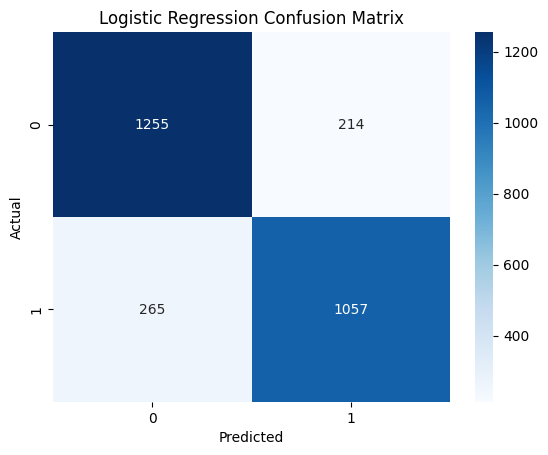

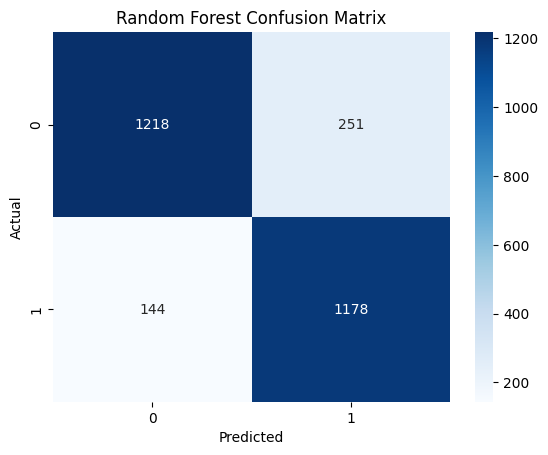

In [28]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")


# **F1 Score**

In [30]:
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr)*100)
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf)*100)


Logistic Regression F1 Score: 81.52718858465097
Random Forest F1 Score: 85.6415848782261


# **Classification Report**

In [31]:
print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1469
           1       0.83      0.80      0.82      1322

    accuracy                           0.83      2791
   macro avg       0.83      0.83      0.83      2791
weighted avg       0.83      0.83      0.83      2791

Random Forest Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1469
           1       0.82      0.89      0.86      1322

    accuracy                           0.86      2791
   macro avg       0.86      0.86      0.86      2791
weighted avg       0.86      0.86      0.86      2791



# **Final Conclusion & Business Insights**


# Final Conclusion:

Based on the classification results, both Logistic Regression and
Random Forest performed well in predicting whether a customer
will subscribe to a term deposit. However, Random Forest showed
overall better performance.

# Model Performance Summary:
- Logistic Regression:
  Accuracy = 83%
  F1-score (Class 1 – Subscription) = 0.82

- Random Forest:
  Accuracy = 86%
  F1-score (Class 1 – Subscription) = 0.86

# Key Insights:
1. Random Forest outperformed Logistic Regression in terms of
   accuracy, recall, and F1-score, especially for the positive
   class (customers who subscribed).
2. Logistic Regression provided balanced performance and good
   interpretability but was slightly weaker in capturing complex
   non-linear relationships.
3. Random Forest achieved higher recall for subscribed customers,
   meaning it identified more potential subscribers correctly.
4. SHAP-based explainability revealed that features such as
   call duration, outcome of previous campaigns, and number of
   customer contacts were the most influential factors.
5. Proper handling of class imbalance contributed to stable and
   reliable model performance.

# Business Impact:
- Banks can use the Random Forest model to better identify
  high-probability customers for term deposit campaigns.
- Improved targeting reduces unnecessary calls and marketing costs.
- Higher recall for potential subscribers increases campaign
  conversion rates and overall profitability.

Overall, this analysis demonstrates that ensemble models combined
with explainable AI techniques provide both high predictive
performance and actionable business insights for data-driven
marketing decisions.
